In [9]:
import OffsetArrays
using DelimitedFiles
using Plots
using IterTools
using Revise
using StatsBase
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
using Distributions
srcpath = "../src"
include("$srcpath/bp.jl")
include("$srcpath/post_infer.jl")
include("$srcpath/observables.jl")
include("$srcpath/single_instance.jl")

build_real_graph (generic function with 1 method)

In [4]:
#import empirical network
edges = readdlm("ia-escorts-dynamic.edges",Int,skipstart=2)[:,1:2];
A = build_real_graph(edges)
Ngraph = nv(A)

10106

# Population dynamics for the messages

In [6]:
degree_dist = empirical_deg_distr(A); 

In [8]:
G = IndexedBiDiGraph(A);

In [10]:
function pdf(cdf_sib)
    N, T = size(cdf_sib) 
    p = zeros(N,T+1)
    p[:,1] .= cdf_sib[:,1]
    for t = 1:T-1
        p[:,t+1] .= cdf_sib[:,t+1] .- cdf_sib[:,t]
    end
    p[:,T+1] .= 1 .- cdf_sib[:,T]
    return p
end
function inf_vs_dil_sib!(AUC,γ, λRange, N, T, G, fr , dilRange)
    Ngraph = nv(G)
    x = zeros(Int,Ngraph, T + 1) # a single epidemic trajectory
    for (λcount,dilcount) in collect(product(1:length(λRange),1:length(dilRange)))
        λi = λp = λRange[λcount]
        dilution = dilRange[dilcount]
        γi = γp = γ
        sample!(x, G, λp, γp)
        O = [(i,Bool(x[i,T+1]),T+1,1e-10) for i = 1:Int(round(Ngraph * (1 - dilution)))]
        O = [rand() > fr ? (o[1],o[2],o[3],fr) : (o[1],!o[2],o[3],fr) for o in O]
        p_sib = sibyl(Ngraph, T+1, G, O, γi, λi; maxit = 50, tol = 1e-20);
        sib_pdf = pdf(p_sib)
        for t = 1:T+1
            AUC[t,λcount,dilcount] += AUROC(ROC(x[:,t], p_sib[:,t]))
        end
    end
end

inf_vs_dil_sib! (generic function with 1 method)

In [ ]:
grid = 12
γ = 0.2
T = 8
N = nv(G)
fr = 0.0
λRange = LinRange(0.01,0.4,grid) 
dilRange = LinRange(0.0,1.0,grid) 
AUC = zeros(T+1,length(λRange),length(dilRange))
inf_vs_dil_sib!(AUC,γ, λRange, N, T, G, fr , dilRange)

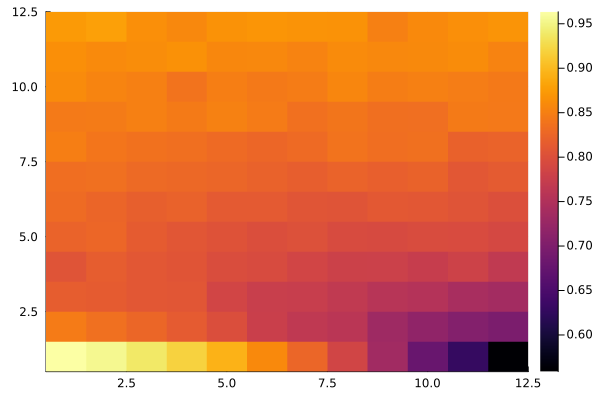

In [21]:
t = 4 # the time at which we evaluate the AUC
heatmap(AUC[t,:,:],xlabel="",ylabel="")